<font size="5"> Проект по прогнозу оттока клиентов для оператора связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.<br> 
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. <br>  Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<font size="4"> Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

 <font size="4">Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Признаки:
- customerID - идентификационный номер клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания пользования услугами
- Type - тип оплаты: ежемесячный, годовой и тд
- PaperlessBilling – безналичный расчет
- PaymentMethod – способ оплаты
- MonthlyCharges – ежемесячные траты на услуги
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

<font size="4">Цель проекта

На основе представленных данных построить модель модель прогнозирования оттока клиентов.<br>
Метрика AUC-ROC модели должна быть не менее 0.85.

# Общая информация о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier


In [2]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [3]:
#CFG
RANDOM_STATE = 231222

In [4]:
try:
    contract = pd.read_csv('D:\\Yandex_practicum\\Final\\data\\contract.csv', index_col='customerID')
    internet = pd.read_csv('D:\\Yandex_practicum\\Final\\data\\internet.csv', index_col='customerID')
    personal = pd.read_csv('D:\\Yandex_practicum\\Final\\data\\personal.csv', index_col='customerID')
    phone = pd.read_csv('D:\\Yandex_practicum\\Final\\data\\phone.csv', index_col='customerID')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
    personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [5]:
data_list = [contract, internet, personal, phone]

In [6]:
for d in data_list:
    display(d.head())
    print(d.info())
    display(d.describe(include='all'))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,5,3,2,4,NaN,6531
top,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None


,MultipleLines
count,6361
unique,2
top,No
freq,3390


Первичный анализ:
- пропусков в данных нет
- целевой признак сформируем преобразованием EndDate
- TotalCharges имеет тип object вероятно из-за 11 пустых значений(необходимо их удалить и изменить тип данных)
- SeniorCitizen имеет числовой тип данных, преобразуем в категориальный

<font size="4">План выполнения проекта

1. Подготовить данные
- объединить таблицы по CustomerID
- заполнить пропуски, удалить дубликаты
- преобразовать типы данных TotalCharges, SeniorCitizen, EndDate, BeginDate
- сформировать целевой признак
2. Провести разведочный анализ(EDA)
3. Подготовить признаки для модели(добавление синтетических, проверка мултиколлинеарности, отбор и кодирование признаков)
4. Обучить и сравнить несколько моделей и выбрать наиболее подходящую(по метрике на кросс-валидации)
5. Протестировать лучшую модель на тестовой выборке
6. Провести анализ важности признаков выбранной модели
7. Написать выводы

# Подготовка данных

## Объединение данных

Объеденим данные в одну таблицу

In [7]:
data = contract.join(other=[internet, personal, phone], how='outer')

In [8]:
#check
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [9]:
#check
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   InternetService   5517 non-null   object 
 8   OnlineSecurity    5517 non-null   object 
 9   OnlineBackup      5517 non-null   object 
 10  DeviceProtection  5517 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  gender            7043 non-null   object 
 15  SeniorCitizen     7043 non-null   int64  
 16  Partner           7043 non-null 

## Обработка пропусков и дубликатов

В объединенной таблице есть пропуски. Отсутствие данных означает, что клиент не пользовался услугой. Заполним их значением 'No'.

In [10]:
data.fillna(value='No', inplace=True)

In [11]:
#check
data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

In [12]:
data.shape

(7043, 19)

In [13]:
data.duplicated().sum()

13

In [14]:
data.index.duplicated().sum()

0

Есть дубликаты, но это разные клиенты с одинаковыми услугами и исходными данными. Учитывая небольшое количество дубликатов, можно их оставить.

## Выделение целевого признака и преобразование типов данных

Сформируем целевой признак

In [15]:
data['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Даты разрыва контрактов представлены четрьмя последними месяцами. 'No' значит, что контракт на момент выгрузки данных не разорван. 

In [16]:
data.loc[data['EndDate'] == 'No', 'target'] = 0 
data.loc[data['EndDate'] != 'No', 'target'] = 1

In [17]:
#check
data.shape

(7043, 20)

Преобразуем типы данных

In [18]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = '2020-02-01 00:00:00'
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [19]:
data.drop(index=data.loc[data['TotalCharges'] == ' '].index, inplace=True)
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [20]:
cat_features = list(data.loc[:, data.dtypes == 'object'].columns.values)
cat_features.append('SeniorCitizen')

In [21]:
data[cat_features] = data[cat_features].astype('category')

In [22]:
#check
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   datetime64[ns]
 2   Type              7032 non-null   category      
 3   PaperlessBilling  7032 non-null   category      
 4   PaymentMethod     7032 non-null   category      
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   InternetService   7032 non-null   category      
 8   OnlineSecurity    7032 non-null   category      
 9   OnlineBackup      7032 non-null   category      
 10  DeviceProtection  7032 non-null   category      
 11  TechSupport       7032 non-null   category      
 12  StreamingTV       7032 non-null   category      
 13  StreamingMovies   7032 non-null   category      
 14  gender        

# EDA

In [23]:
data['target'].value_counts()

0.0    5163
1.0    1869
Name: target, dtype: int64

В данных присутствует дисбаланс классов, учтем это при обучении моделей

Построим распределение количества ушедших и оставшихся клиентов по категориальным признакам

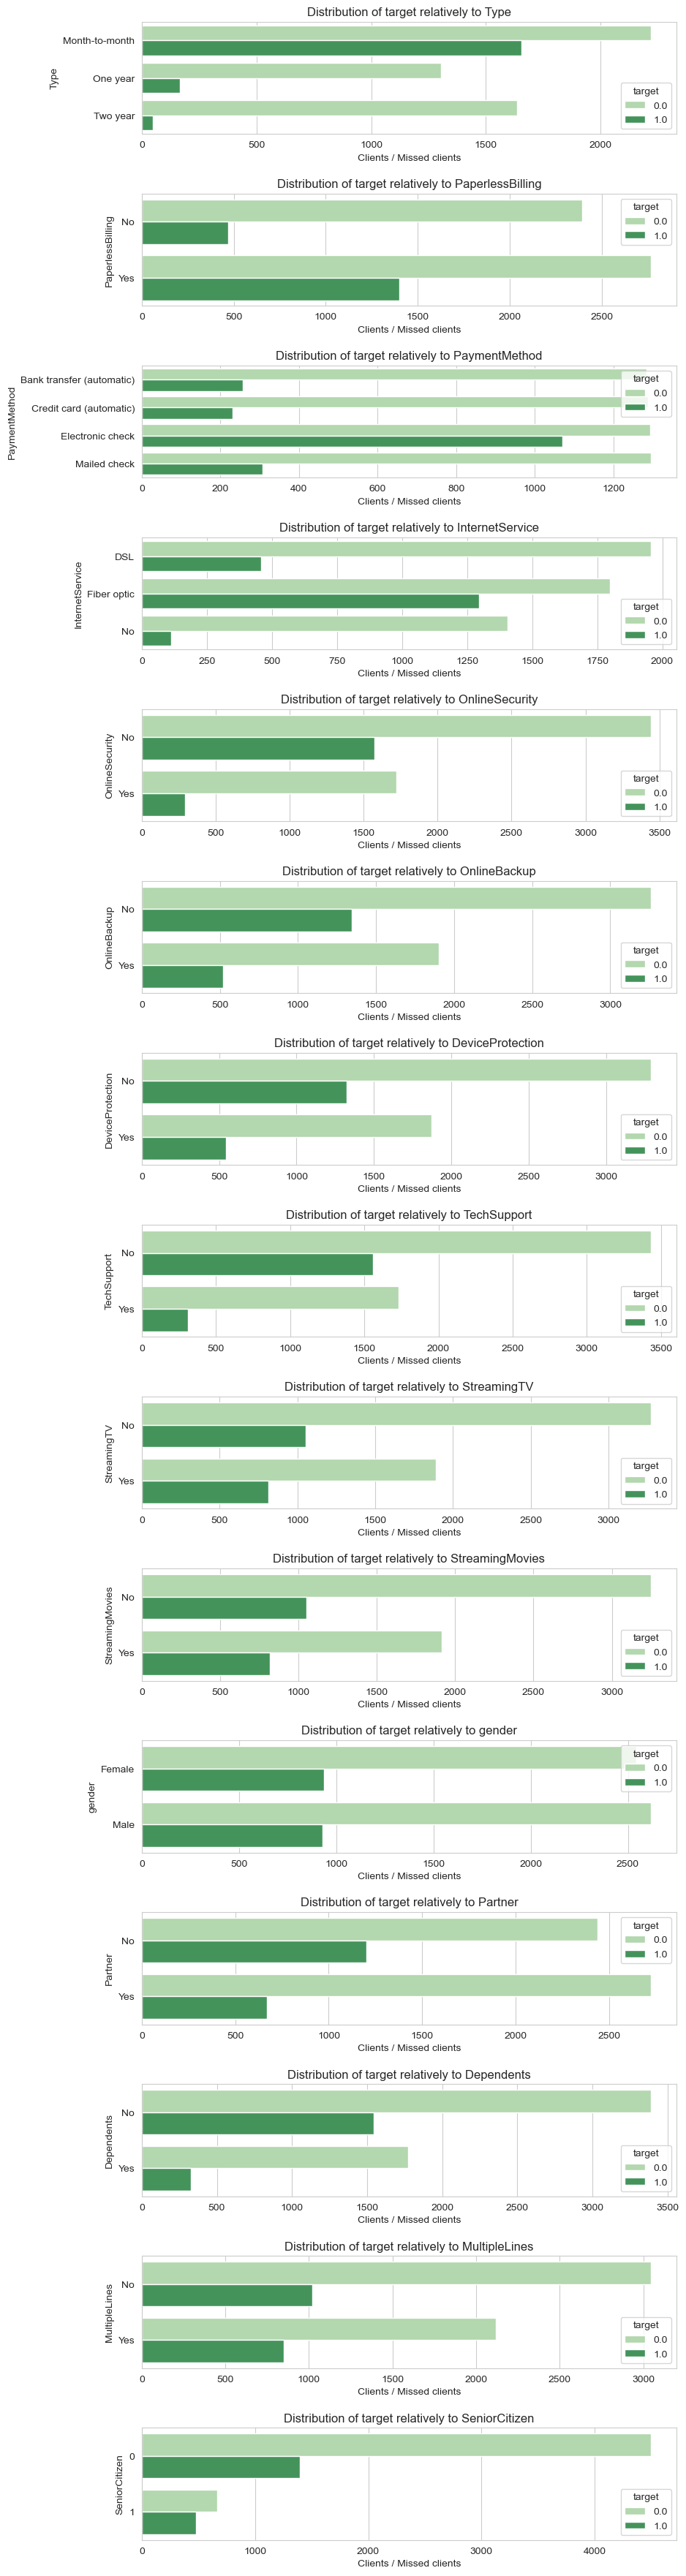

In [24]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(len(cat_features), 1, figsize=(8, 35));
fig.tight_layout(h_pad=4)
for ind, cat in enumerate(cat_features):
    sns.countplot(data=data, 
                  y=cat, 
                  hue='target',
                  orient='h', 
                  palette='Greens', 
                  ax=axes.flatten()[ind]);
    axes[ind].set_xlabel('Clients / Missed clients')
    axes[ind].set_title(f'Distribution of target relatively to {cat}');

- существенно реже разрывают контракт клиенты, оплачивающие услуги на год/два вперед
- клиенты, выбирающие безналичный расчет несколько чаще покидают оператора
- клиенты, выбирающие электронную оплату, значительно чаще отказываются от услуг оператора
- клиенты, пользующиеся оптоволокном, чаще отказываются от услуг оператора

Оценим средние значения числовых признаков по ушедшим/оставшимся клиентам

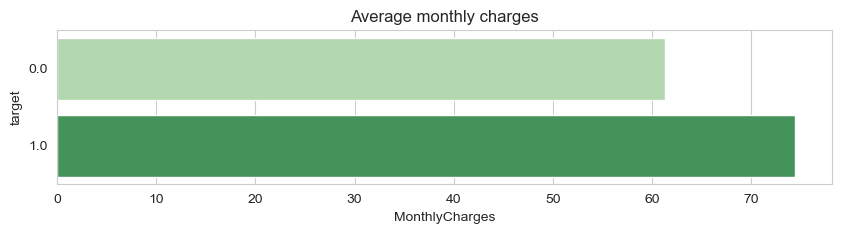

In [25]:
plt.figure(figsize=(10,2))
sns.barplot(data=data, 
            x='MonthlyCharges', 
            y='target', 
            orient='h', 
            errorbar=None, 
            palette='Greens');
plt.title('Average monthly charges');

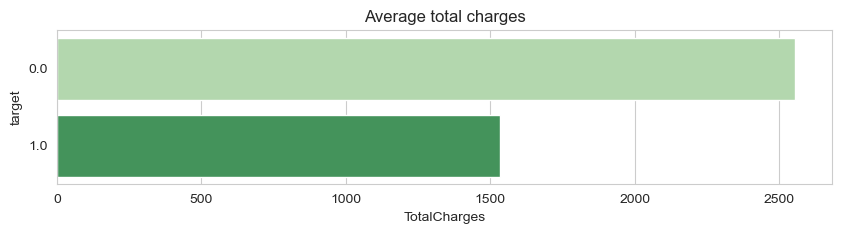

In [26]:
plt.figure(figsize=(10,2))
sns.barplot(data=data, 
            x='TotalCharges', 
            y='target', 
            orient='h', 
            errorbar=None, 
            palette='Greens');
plt.title('Average total charges');

Оценим как менялось количество ушедших клиентов по годам

In [27]:
data['BeginYear'] = data['BeginDate'].dt.year

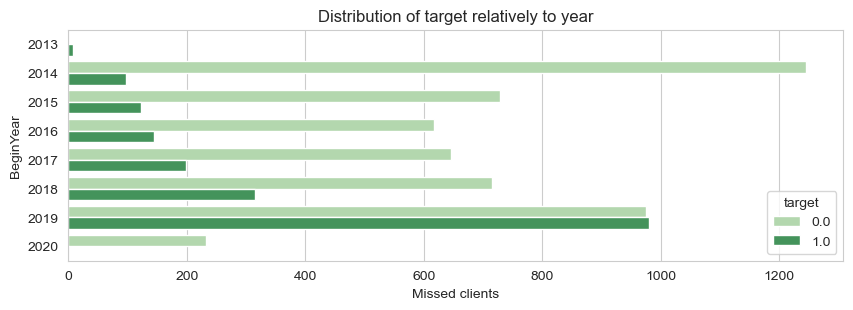

In [28]:
plt.figure(figsize=(10, 3))
sns.countplot(data=data, 
              y='BeginYear', 
              hue='target',
              orient='h', 
              palette='Greens');
plt.xlabel('Missed clients')
plt.title('Distribution of target relatively to year');

Портрет клиента, разрывающего контракт:
- использует помесячную оплату
- использует безналичный расчет
- использует электронную оплату
- пользуется оптоволокном
- заключил договор в 2019 году


# Подготовка признаков

## Feature Engineering

Добавим признак - длительность контракта

In [29]:
data.shape

(7032, 21)

In [30]:
data['duration'] = (data['EndDate'] - data['BeginDate']).dt.days

Исключим признаки BeginDate, EndDate, BeginYear

In [31]:
data.drop(columns=['EndDate', 'BeginDate', 'BeginYear'], inplace=True)

In [32]:
#check
data.shape

(7032, 19)

## Проверка на мультиколлинеарность

In [33]:
phik_overview = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'duration']).round(2)

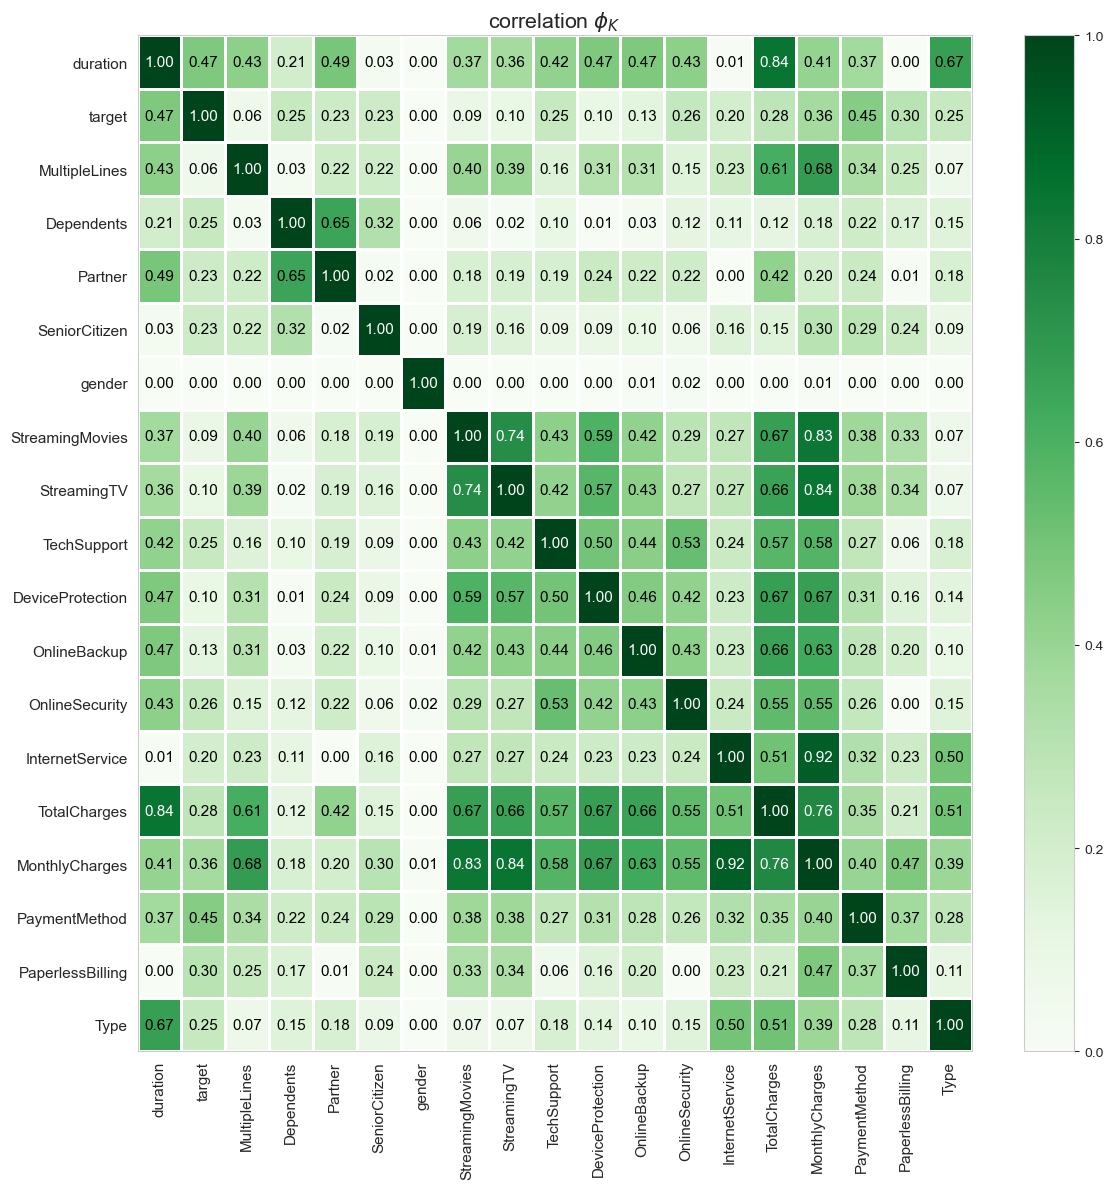

In [34]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', 
                        title=r'correlation $\phi_K$', 
                        fontsize_factor=1.1, 
                        figsize=(12, 12))
plt.tight_layout()

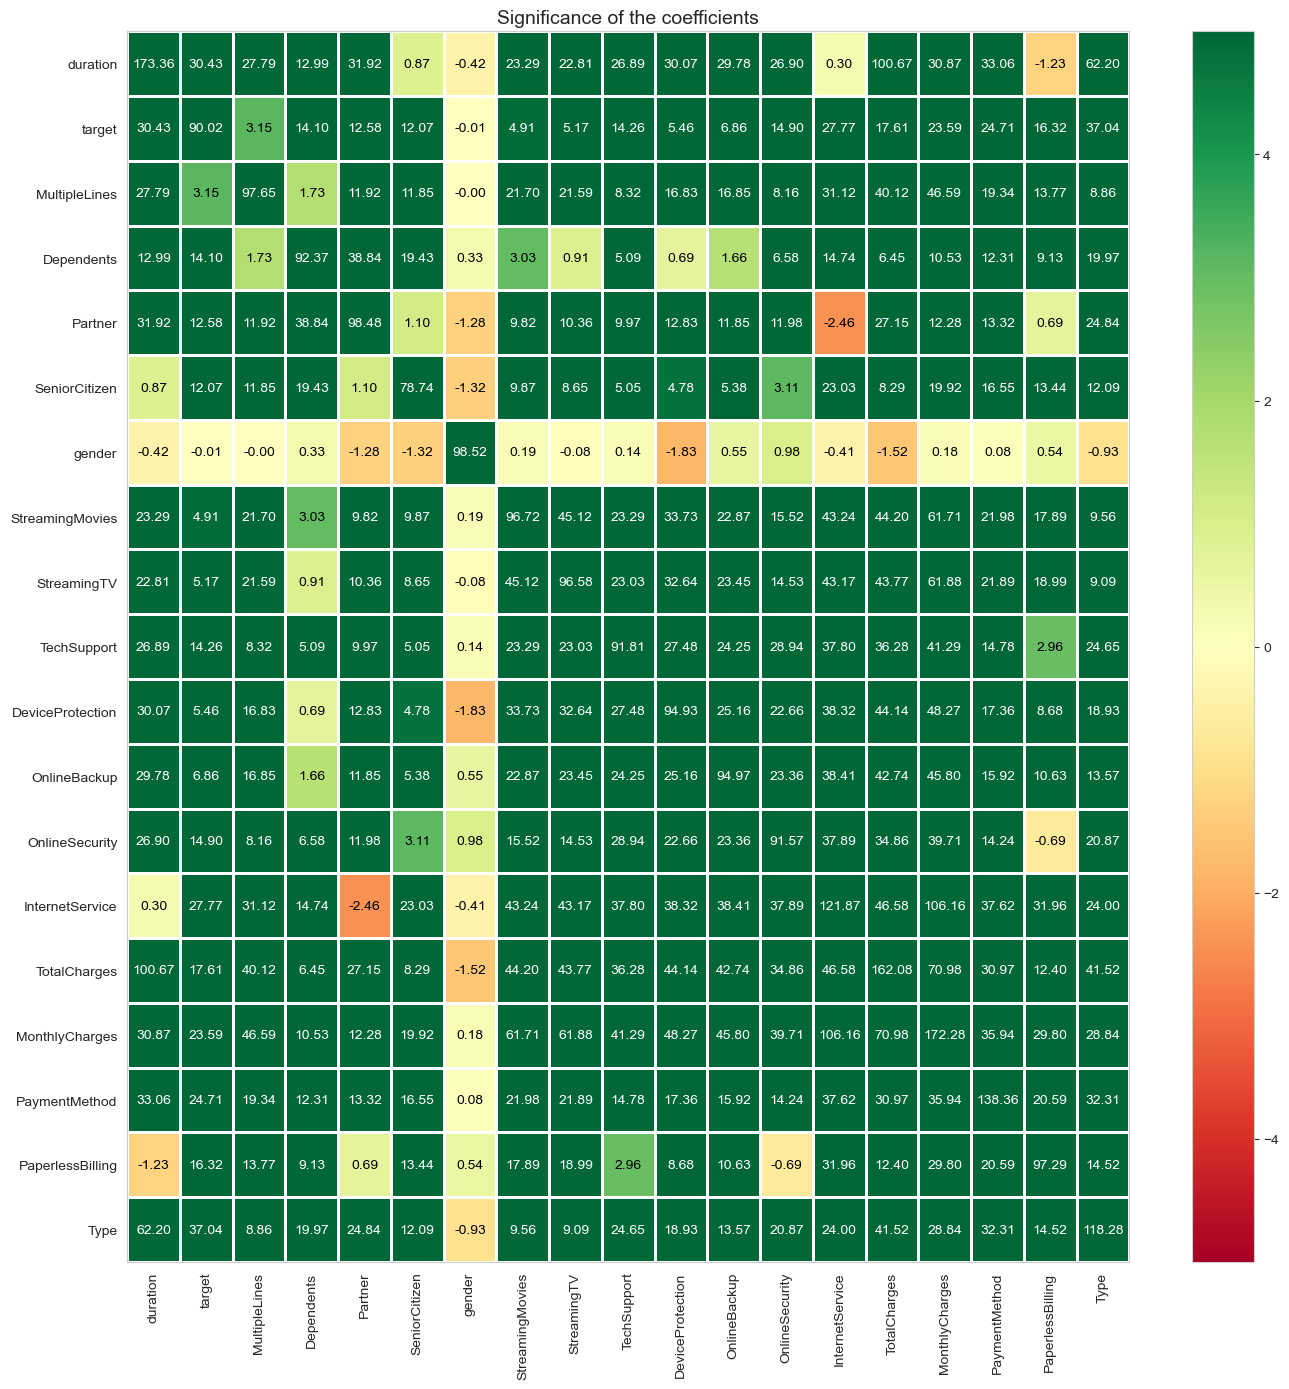

In [35]:
significance_overview = data.significance_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'duration'])
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title='Significance of the coefficients', 
                        usetex=False, fontsize_factor=1.0, figsize=(14, 14))
plt.tight_layout()

В данных между рядом признаков присутствует мультиколлинеарность. Исключать эти признаки не будем, т.к. использовать будем модели основанные на деревьях решений.

Также в данных есть признаки, имеющие низкую зависимость с целевой переменной. На данном этапе исключать их не будем, т.к. будем использовать отбор значимых признаков перед обучением моделей.

## Кодирование признаков и разбиениие на тренировочную и тестовую выборки

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7032 non-null   category
 1   PaperlessBilling  7032 non-null   category
 2   PaymentMethod     7032 non-null   category
 3   MonthlyCharges    7032 non-null   float64 
 4   TotalCharges      7032 non-null   float64 
 5   InternetService   7032 non-null   category
 6   OnlineSecurity    7032 non-null   category
 7   OnlineBackup      7032 non-null   category
 8   DeviceProtection  7032 non-null   category
 9   TechSupport       7032 non-null   category
 10  StreamingTV       7032 non-null   category
 11  StreamingMovies   7032 non-null   category
 12  gender            7032 non-null   category
 13  SeniorCitizen     7032 non-null   category
 14  Partner           7032 non-null   category
 15  Dependents        7032 non-null   category
 16  MultipleLines 

In [37]:
features = data.drop(columns='target')
target = data['target']

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [39]:
#check
target_train[target_train == 1].count() / target_train[target_train == 0].count()

0.36208677685950413

In [40]:
#check
target_test[target_test == 1].count() / target_test[target_test == 0].count()

0.36173508907823393

Обучать будем модели, основанные на деревьях решений. Метод кодирования признаков OHE или OE будем определять в рамках RandomizedSearchCV, числовые признаки оставляем как есть.

In [41]:
cat_transformer = ColumnTransformer(transformers=[('cat', OrdinalEncoder(), selector(dtype_include='category'))],
                                    remainder='passthrough')

In [42]:
preprocessor = Pipeline(steps=[('transformer', cat_transformer),
                               ('select', SelectFromModel(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE,
                                                                                           class_weight='balanced')))])

In [43]:
#check
print(features_train.shape)
print(features_test.shape)

(5274, 18)
(1758, 18)


# Обучение моделей

## LGBMClassifier

In [44]:
lgbm_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LGBMClassifier(random_state=RANDOM_STATE,
                                                          n_jobs=12,
                                                          is_unbalance=True))])

In [45]:
scoring = {"AUC": "roc_auc", "Accuracy": 'accuracy'}

In [46]:
np.random.seed(RANDOM_STATE)

In [47]:
param_dist = {'classifier__n_estimators' : np.random.randint(800, 1000, size=20),
              'classifier__max_depth' : np.random.randint(1, 10, size=10),
              'classifier__min_split_gain' : np.random.uniform(0.0, 1.0, size=20),
              'classifier__learning_rate' : np.random.uniform(0.1, 0.4, size=20),
              'classifier__min_child_samples' : np.random.randint(1, 10, size=10),
              'preprocessor__select__threshold' : np.random.uniform(0.01, 0.1, size=20),
              'preprocessor__select__estimator__criterion' : ['gini', 'entropy'],
              'preprocessor__select__estimator__max_depth' : np.random.randint(1, 6, size=5),
              'preprocessor__transformer__cat' : [OrdinalEncoder(), OneHotEncoder()]}


search_lgbm = RandomizedSearchCV(estimator=lgbm_pipe,
                                 param_distributions=param_dist,
                                 n_iter=1000,
                                 cv=3,
                                 scoring=scoring,
                                 refit='AUC',
                                 random_state=RANDOM_STATE,
                                 n_jobs=-1,
                                 verbose=2)

In [48]:
search_lgbm.fit(features_train, target_train);

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


In [49]:
pd.DataFrame(search_lgbm.best_params_.values(), 
             index=search_lgbm.best_params_.keys(),
             columns=['best_params'])

,best_params
preprocessor__transformer__cat,OneHotEncoder()
preprocessor__select__threshold,0.07558
preprocessor__select__estimator__max_depth,3
preprocessor__select__estimator__criterion,entropy
classifier__n_estimators,833
classifier__min_split_gain,0.072748
classifier__min_child_samples,5
classifier__max_depth,4
classifier__learning_rate,0.347625


In [50]:
lgbm_best_cv = pd.DataFrame(search_lgbm.cv_results_)[['mean_test_AUC', 'mean_test_Accuracy']].sort_values(by='mean_test_AUC',
                                                                                                          ascending=False).head(1)
display(lgbm_best_cv)

,mean_test_AUC,mean_test_Accuracy
503,0.924283,0.845848


In [51]:
dt_fip = pd.DataFrame(data=search_lgbm.best_estimator_['preprocessor']['select'].estimator_.feature_importances_,
                      index=search_lgbm.best_estimator_['preprocessor']['transformer'].get_feature_names_out(),
                      columns=['fip']).sort_values(by='fip', ascending=False).head()

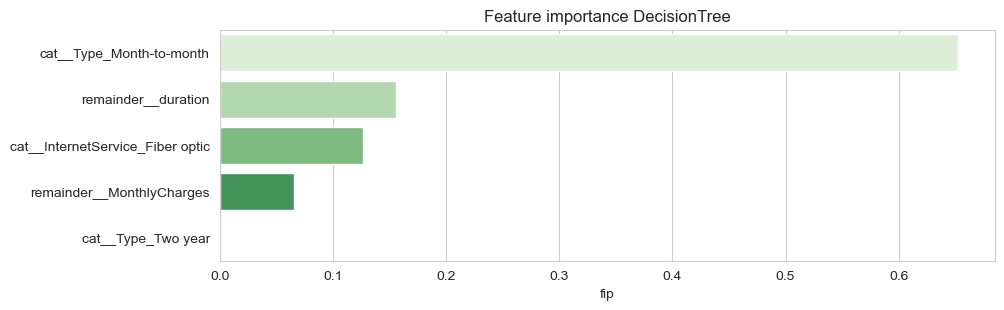

In [52]:
plt.figure(figsize=(10, 3))
sns.barplot(data=dt_fip, x='fip', y=dt_fip.index, palette='Greens');
plt.title('Feature importance DecisionTree');

In [53]:
lgbm_fip = pd.DataFrame(data=search_lgbm.best_estimator_['classifier'].feature_importances_,
                        index=search_lgbm.best_estimator_['preprocessor']['transformer'].get_feature_names_out()[
                              search_lgbm.best_estimator_['preprocessor']['select'].get_support()],
                        columns=['fip'])

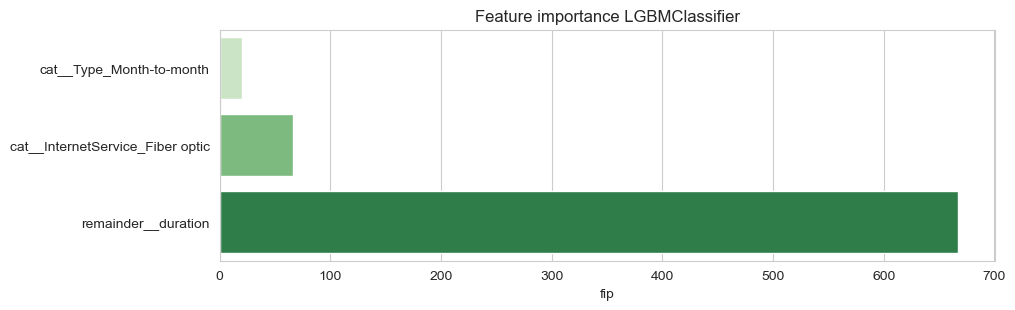

In [54]:
plt.figure(figsize=(10, 3))
sns.barplot(data=lgbm_fip, x='fip', y=lgbm_fip.index, palette='Greens');
plt.title('Feature importance LGBMClassifier');

In [55]:
model_lgbm = search_lgbm.best_estimator_

## CatBoostClassifier

In [56]:
cat_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', CatBoostClassifier(random_seed=RANDOM_STATE,
                                                             silent=True, 
                                                             leaf_estimation_method='Gradient',
                                                             auto_class_weights='Balanced'))])

In [57]:
param_dist = {'classifier__iterations' : np.random.randint(800, 1100, size=30),
              'classifier__depth' : np.random.randint(1, 10, size=10),
              'classifier__learning_rate' : np.random.uniform(0.1, 0.3, size=20),
              'classifier__leaf_estimation_iterations' : np.random.randint(300, 400, size=20),
              'classifier__l2_leaf_reg' : np.random.uniform(4.0, 6.0, size=20),
              'preprocessor__select__threshold' : np.random.uniform(0.01, 0.1, size=20),
              'preprocessor__select__estimator__criterion' : ['gini', 'entropy'],
              'preprocessor__select__estimator__max_depth' : np.random.randint(1, 6, size=5),
              'preprocessor__transformer__cat' : [OrdinalEncoder(), OneHotEncoder()]}


search_cat = RandomizedSearchCV(estimator=cat_pipe,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=3,
                                scoring=scoring,
                                refit='AUC',
                                random_state=RANDOM_STATE,
                                n_jobs=-1,
                                verbose=2)


In [58]:
search_cat.fit(features_train, target_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [59]:
pd.DataFrame(search_cat.best_params_.values(), 
             index=search_cat.best_params_.keys(),
             columns=['best_params'])

,best_params
preprocessor__transformer__cat,OneHotEncoder()
preprocessor__select__threshold,0.085073
preprocessor__select__estimator__max_depth,3
preprocessor__select__estimator__criterion,gini
classifier__learning_rate,0.131591
classifier__leaf_estimation_iterations,370
classifier__l2_leaf_reg,4.873834
classifier__iterations,980
classifier__depth,4


In [60]:
cat_best_cv = pd.DataFrame(search_cat.cv_results_)[['mean_test_AUC', 'mean_test_Accuracy']].sort_values(by='mean_test_AUC',
                                                                                                        ascending=False).head(1)
display(cat_best_cv)


,mean_test_AUC,mean_test_Accuracy
14,0.939696,0.860447


In [61]:
dt_fip = pd.DataFrame(data=search_cat.best_estimator_['preprocessor']['select'].estimator_.feature_importances_,
                      index=search_cat.best_estimator_['preprocessor']['transformer'].get_feature_names_out(),
                      columns=['fip']).sort_values(by='fip', ascending=False).head()

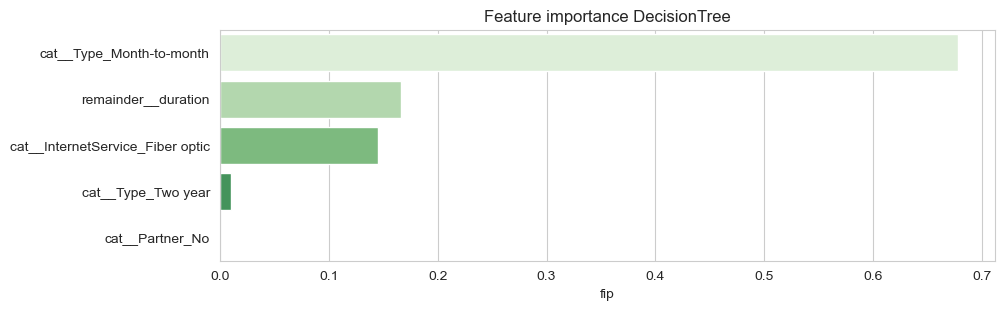

In [62]:
plt.figure(figsize=(10, 3))
sns.barplot(data=dt_fip, x='fip', y=dt_fip.index, palette='Greens');
plt.title('Feature importance DecisionTree');

In [63]:
cat_fip = pd.DataFrame(data=search_cat.best_estimator_['classifier'].feature_importances_,
                       index=search_cat.best_estimator_['preprocessor']['transformer'].get_feature_names_out()[
                              search_cat.best_estimator_['preprocessor']['select'].get_support()],
                       columns=['fip'])

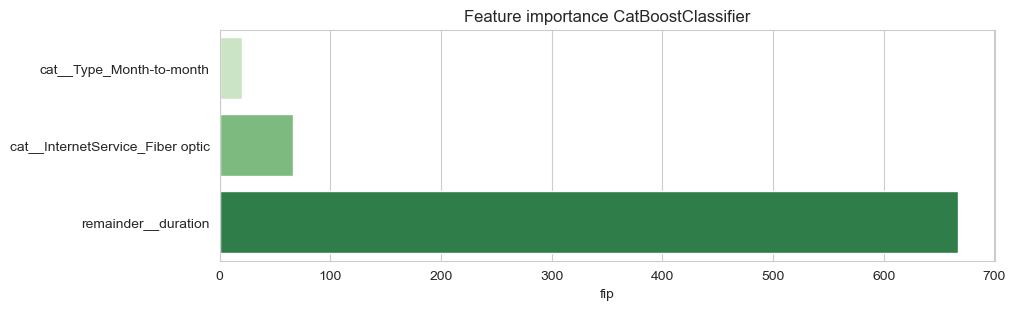

In [64]:
plt.figure(figsize=(10, 3))
sns.barplot(data=lgbm_fip, x='fip', y=lgbm_fip.index, palette='Greens');
plt.title('Feature importance CatBoostClassifier');

In [65]:
model_cat = search_cat.best_estimator_

In [66]:
pd.DataFrame(np.concatenate([lgbm_best_cv, cat_best_cv]),
             index=['LGBM','CatBoost'],
             columns=['ROC-AUC', 'Accuracy'])

,ROC-AUC,Accuracy
LGBM,0.924283,0.845848
CatBoost,0.939696,0.860447


- Лучшие метрики у CatBoostClassifier, дальнейшее тестирование будем проводить с ней
- Наиболее значимый признак - длительность контракта клиента

# Тестирование модели

## Метрики модели

In [67]:
preds_cat = model_cat.predict(features_test)

In [68]:
print('ROC-AUC CatBoostClassifier', roc_auc_score(target_test, model_cat.predict_proba(features_test)[:, 1]))
print('Accuracy CatBoostClassifier', accuracy_score(target_test, preds_cat))

ROC-AUC CatBoostClassifier 0.9451440295771913
Accuracy CatBoostClassifier 0.8577929465301479


In [69]:
print(classification_report(target_test, preds_cat))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1291
         1.0       0.68      0.88      0.77       467

    accuracy                           0.86      1758
   macro avg       0.82      0.86      0.83      1758
weighted avg       0.88      0.86      0.86      1758



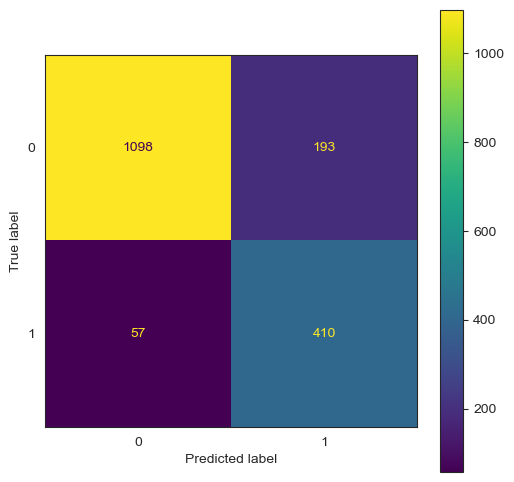

In [70]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(confusion_matrix(target_test, preds_cat)).plot(ax=ax);

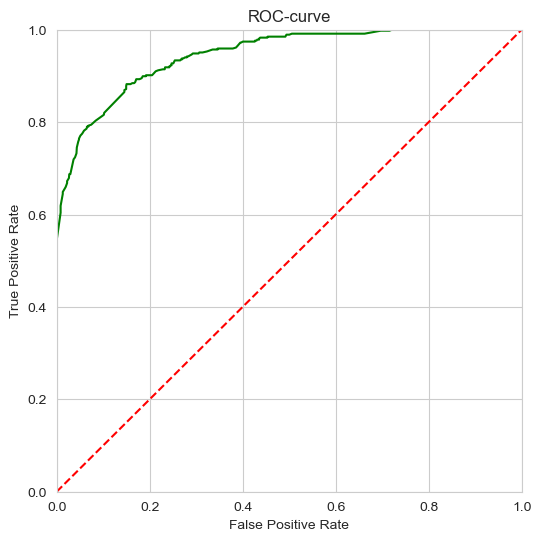

In [71]:
fpr, tpr, thresholds = roc_curve(target_test, model_cat.predict_proba(features_test)[:, 1])
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve');

- По результатам тестирования модель имеет достаточно высокое качество
- Целевая метрика AUC-ROC - 0.945, что значительно выше целей проекта - 0.85
- Значение Accuracy - 0.858
- Дисбаланс классов учтен, итоговые значения полноты и точности модели по положительному классу - 0.88 и 0.68 соответственно

# Выводы

- Разработанная модель удовлетворяет целям проекта и позволяет прогнозировать отток клиентов с достаточно высокой точностью и полнотой
- В зависимости от конкретных задач бизнеса можно подстраивать модель и увеличивать точность или полноту предсказаний
- Достигнута целевая метрика модели AUC-ROC - 0.945, accuracy - 0.858
- Precision и recall модели также на достаточно высоком уровне и составляют 0.68 и 0.88 соответственно
- В ходе исследования данных выявлено, что существенный отток клиентов от оператора начался в 2019 году, вероятно бизнесу следует проанализировать изменения, произошедшие на рынке услуг связи в 2019 году, с целью установления причин оттока клиентов